In [77]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [79]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


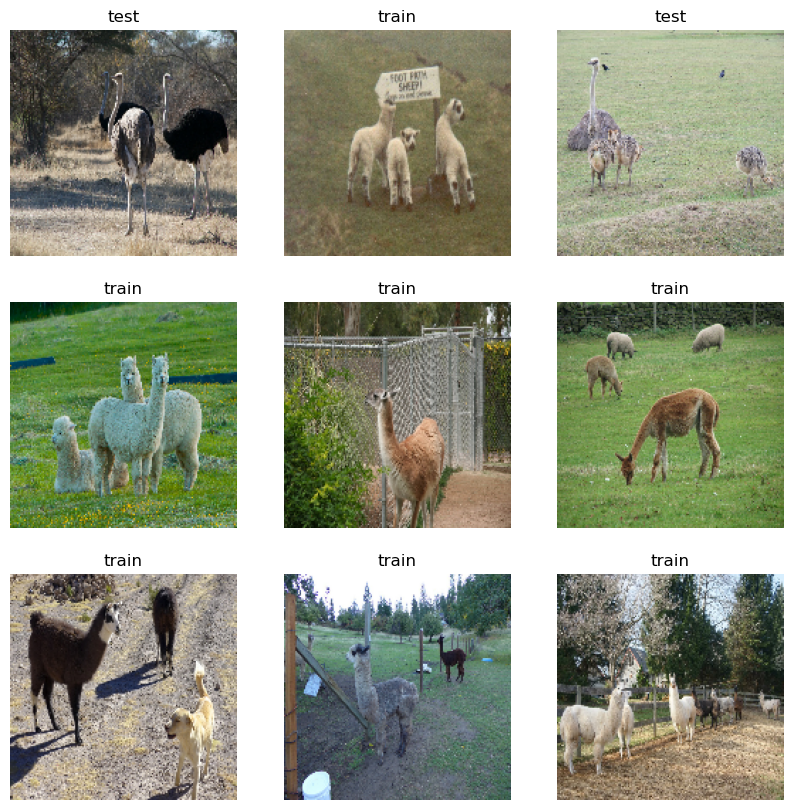

In [81]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [83]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [85]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [87]:
config = augmenter.layers[1].get_config()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RandomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert 'factor' in config, "Factor attribute is missing in the config"
assert config['factor'] == [-0.2, 0.2], "Rotation factor must be [-0.2, 0.2]"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


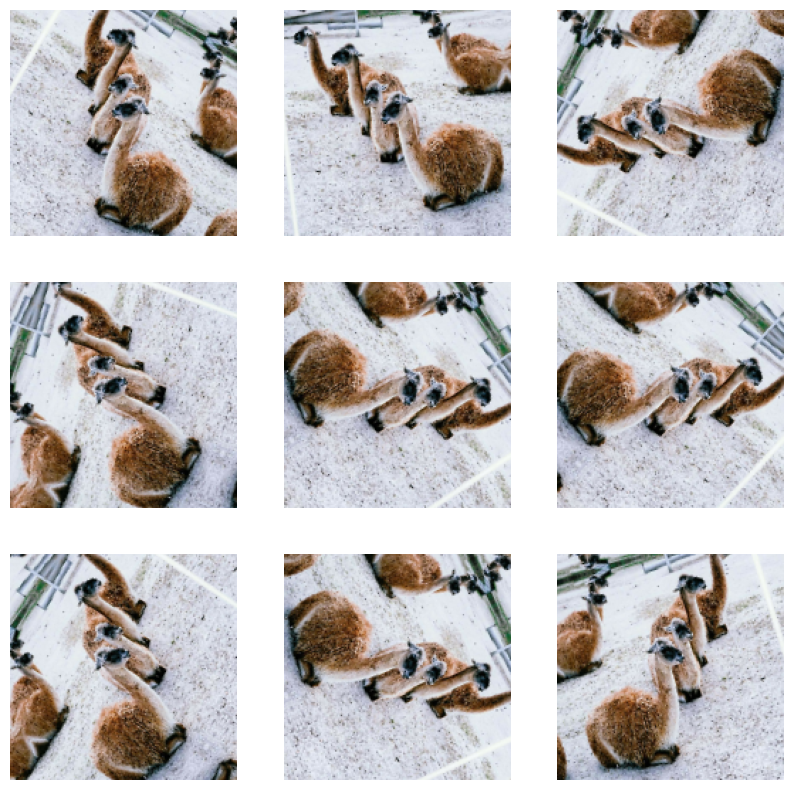

In [89]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [91]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [93]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [95]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_1
predictions


In [97]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [99]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0])>

In [101]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


[[('n01518878', 'ostrich', 0.9294675), ('n02018795', 'bustard', 0.003946685)],
 [('n09193705', 'alp', 0.70326144), ('n09468604', 'valley', 0.036619764)],
 [('n02437616', 'llama', 0.4462981), ('n02410509', 'bison', 0.20282707)],
 [('n02509815', 'lesser_panda', 0.23589157),
  ('n02133161', 'American_black_bear', 0.13735904)],
 [('n02133161', 'American_black_bear', 0.2922532),
  ('n02134418', 'sloth_bear', 0.15884833)],
 [('n02437312', 'Arabian_camel', 0.91129637),
  ('n02444819', 'otter', 0.0091526015)],
 [('n02437616', 'llama', 0.9874098),
  ('n02437312', 'Arabian_camel', 0.0071414607)],
 [('n04296562', 'stage', 0.15164502), ('n03970156', 'plunger', 0.09745845)],
 [('n02133161', 'American_black_bear', 0.41856053),
  ('n02134418', 'sloth_bear', 0.41853458)],
 [('n02134418', 'sloth_bear', 0.2560965), ('n02484975', 'guenon', 0.15423599)],
 [('n02437616', 'llama', 0.34926686), ('n01518878', 'ostrich', 0.18427736)],
 [('n01518878', 'ostrich', 0.99683857),
  ('n02106382', 'Bouvier_des_Flandre

In [103]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights="imagenet") # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    prediction_layer = tfl.Dense(1)
    outputs = prediction_layer(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [105]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


In [113]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [115]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - accuracy: 0.5184 - loss: 0.7603 - val_accuracy: 0.7231 - val_loss: 0.5740
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.7450 - loss: 0.5667 - val_accuracy: 0.7231 - val_loss: 0.5341
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.7002 - loss: 0.5598 - val_accuracy: 0.7077 - val_loss: 0.5055
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.7594 - loss: 0.4703 - val_accuracy: 0.8615 - val_loss: 0.4642
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.7559 - loss: 0.5041 - val_accuracy: 0.7385 - val_loss: 0.4577


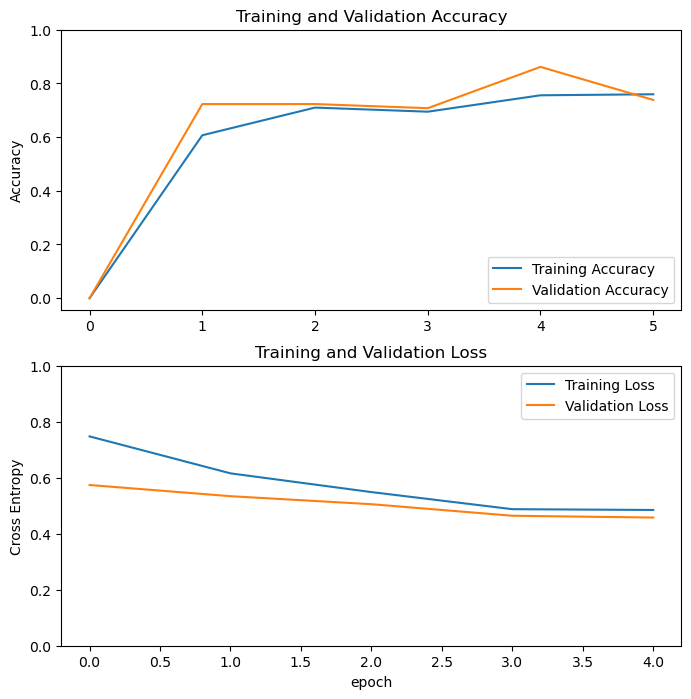

In [117]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [119]:
class_names

['test', 'train']

In [127]:
# UNQ_C3
base_model = model2.get_layer('mobilenetv2_1.00_160')  # Or any other valid layer
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics = ['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [141]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.learning_rate == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')

All tests passed!


In [143]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step - accuracy: 0.7297 - loss: 0.5359 - val_accuracy: 0.7231 - val_loss: 0.4586
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.8132 - loss: 0.3788 - val_accuracy: 0.6769 - val_loss: 0.4682
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.8181 - loss: 0.3584 - val_accuracy: 0.6923 - val_loss: 0.4779
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.8599 - loss: 0.3357 - val_accuracy: 0.6769 - val_loss: 0.5106
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.9325 - loss: 0.2000 - val_accuracy: 0.7231 - val_loss: 0.4856
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.9128 - loss: 0.2572 - val_accuracy: 0.8000 - val_loss: 0.4779


In [145]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

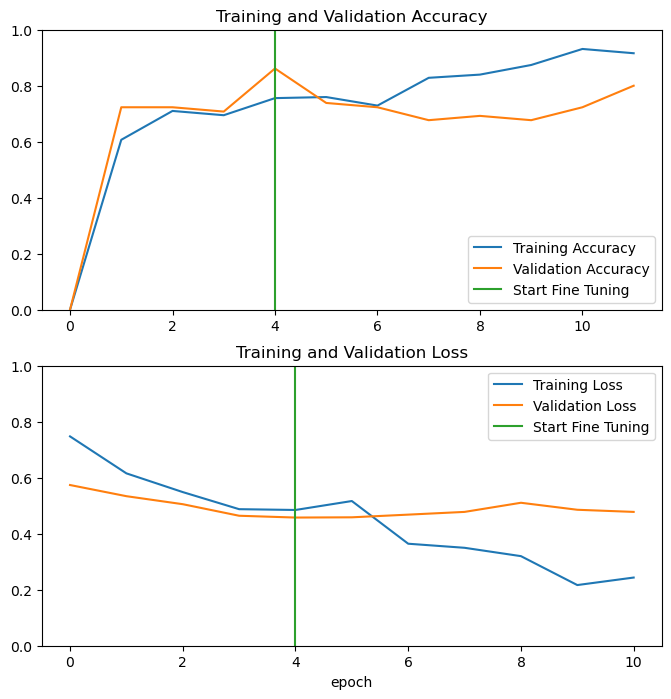

In [147]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()